# Inspect Mask R-CNN Model

In [1]:
import os
import sys

import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = './'

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import cElegans

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
BALLON_WEIGHTS_PATH = "./mask_rcnn_custom.h5"  

/Users/imkeschwenke/Programmieren/InstanceSegmentation/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Configuration

In [2]:
config = cElegans.CElegansConfig()
DATA_DIR = os.path.join(ROOT_DIR, 'dataset')

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

### Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Load Validation Dataset

In [6]:
# Load validation dataset
dataset = cElegans.CElegansDataset()
dataset.load_c_elegans(DATA_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 215
Classes: ['BG', 'c_elegans']


### Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

Instructions for updating:
Use fn_output_signature instead


In [8]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
weights_path = "./mask_rcnn_custom2.h5"

# # Or, load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  ./mask_rcnn_custom2.h5


2024-09-11 16:27:08.527986: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


### Evaluate Model

In [ ]:
import matplotlib.pyplot as plt

def plot_precision_recall(precisions, recalls):
    # Precision-Recall-Kurve plotten
    plt.plot(recalls, precisions, 'b', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Beispiel: Precision-Recall-Kurve für ein Bild
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'], iou_threshold=0.5)
plot_precision_recall(precisions, recalls)


### Run Detection

image ID: c_elegans.136 (135) ./dataset/val/0130-8.png
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  151.00000  uint8
image_meta               shape: (14,)                 min:    1.00000  max: 1024.00000  int64
gt_class_id              shape: (22,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (22, 4)               min:   25.00000  max:  971.00000  int32
gt_mask                  shape: (1024, 1024, 22)      min:    0.00000  max:    1.00000  bool


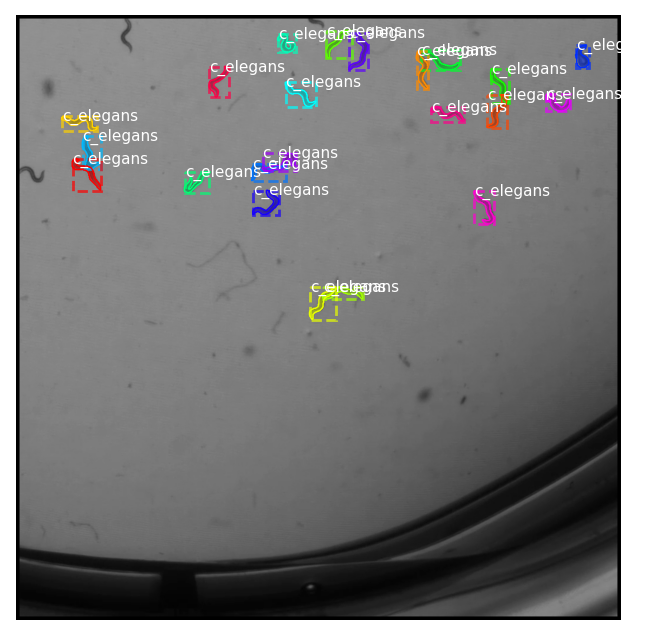

In [10]:
from mrcnn import utils
# Test on a random image
image_id = np.random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config,
                           image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
mask = utils.expand_mask(gt_bbox, gt_mask, image.shape)
log("original_image", image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", mask)

visualize.display_instances(image, gt_bbox, mask, gt_class_id,
                            dataset.class_names, figsize=(8, 8))

In [ ]:
# Run object detection
results = model.detect([image], verbose=1)
r = results[0]

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  161.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   57.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32


/Users/imkeschwenke/Programmieren/InstanceSegmentation/.venv/lib/python3.9/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-11 14:30:21.646423: W tensorflow/c/c_api.cc:304] Operation '{name:'bn5b_branch2b/moving_mean/Assign' id:5182 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node bn5b_branch2b/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bn5b_branch2b/moving_mean, bn5b_branch2b/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-09-11 14:30:23.633676: W tensorflow/core/grappler/c

image ID: c_elegans.8 (7) ./dataset/val/2022-5.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  161.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   57.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
gt_class_id              shape: (13,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (13, 4)               min:   40.00000  max:  964.00000  int32
gt_mask                  shape: (56, 56, 13)          min:    0.00000  max:    1.00000  bool


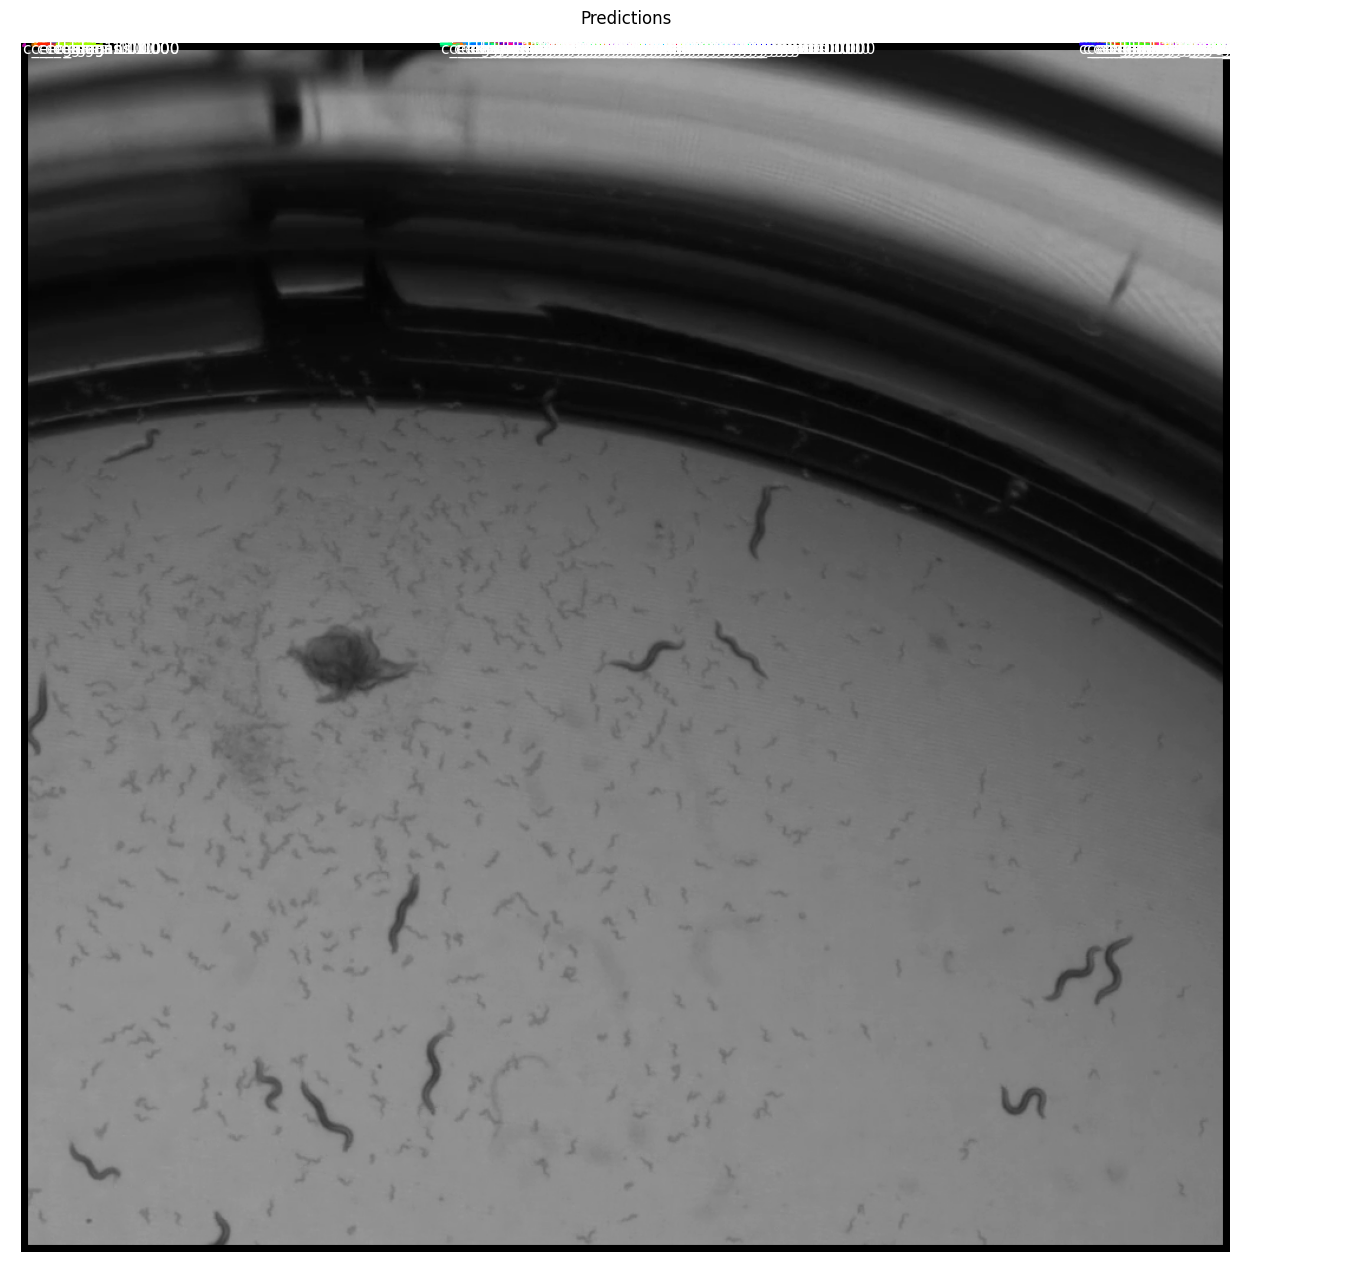

In [ ]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Step by Step Prediction

### Stage 1: Regional Proposal Network
The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high objectness score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

#### 1.a RPN Targets
The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [ ]:
anchors = model.get_anchors(config.IMAGE_SHAPE)
print(anchors.shape)

(261888, 4)


In [ ]:
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)
print("Positive anchors:", np.sum(target_rpn_match == 1))

target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -6.40816  max:    5.05179  float64
Positive anchors: 24


In [ ]:
positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
print(positive_anchors.shape)
print(target_rpn_bbox[:positive_anchors.shape[0]].shape)

(24, 4)
(24, 4)


In [ ]:
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

positive_anchors         shape: (24, 4)               min:   41.37258  max:  963.31371  float64
negative_anchors         shape: (232, 4)              min:   -8.00000  max: 1037.25483  float64
neutral anchors          shape: (261632, 4)           min: -181.01934  max: 1141.01934  float64
refined_anchors          shape: (24, 4)               min:   40.00000  max:  964.00006  float32


In [ ]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=positive_anchors,
    refined_boxes=refined_anchors)

NameError: name 'image' is not defined

#### 1.b RPN Predictions
Here we run the RPN graph and display its predictions

In [ ]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph(image[np.newaxis], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
], image_metas=image_meta[np.newaxis])

2024-09-11 14:47:27.903499: W tensorflow/c/c_api.cc:304] Operation '{name:'rpn_class/concat' id:5878 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node rpn_class/concat}} = ConcatV2[N=5, T=DT_FLOAT, Tidx=DT_INT32, _has_manual_control_dependencies=true, _device="/device:CPU:0"](rpn_model/rpn_class_xxx/Softmax, rpn_model_1/rpn_class_xxx/Softmax, rpn_model_2/rpn_class_xxx/Softmax, rpn_model_3/rpn_class_xxx/Softmax, rpn_model_4/rpn_class_xxx/Softmax, rpn_class/concat/axis)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.01106  max:    1.00715  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.05585  max:    1.02431  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 1124.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


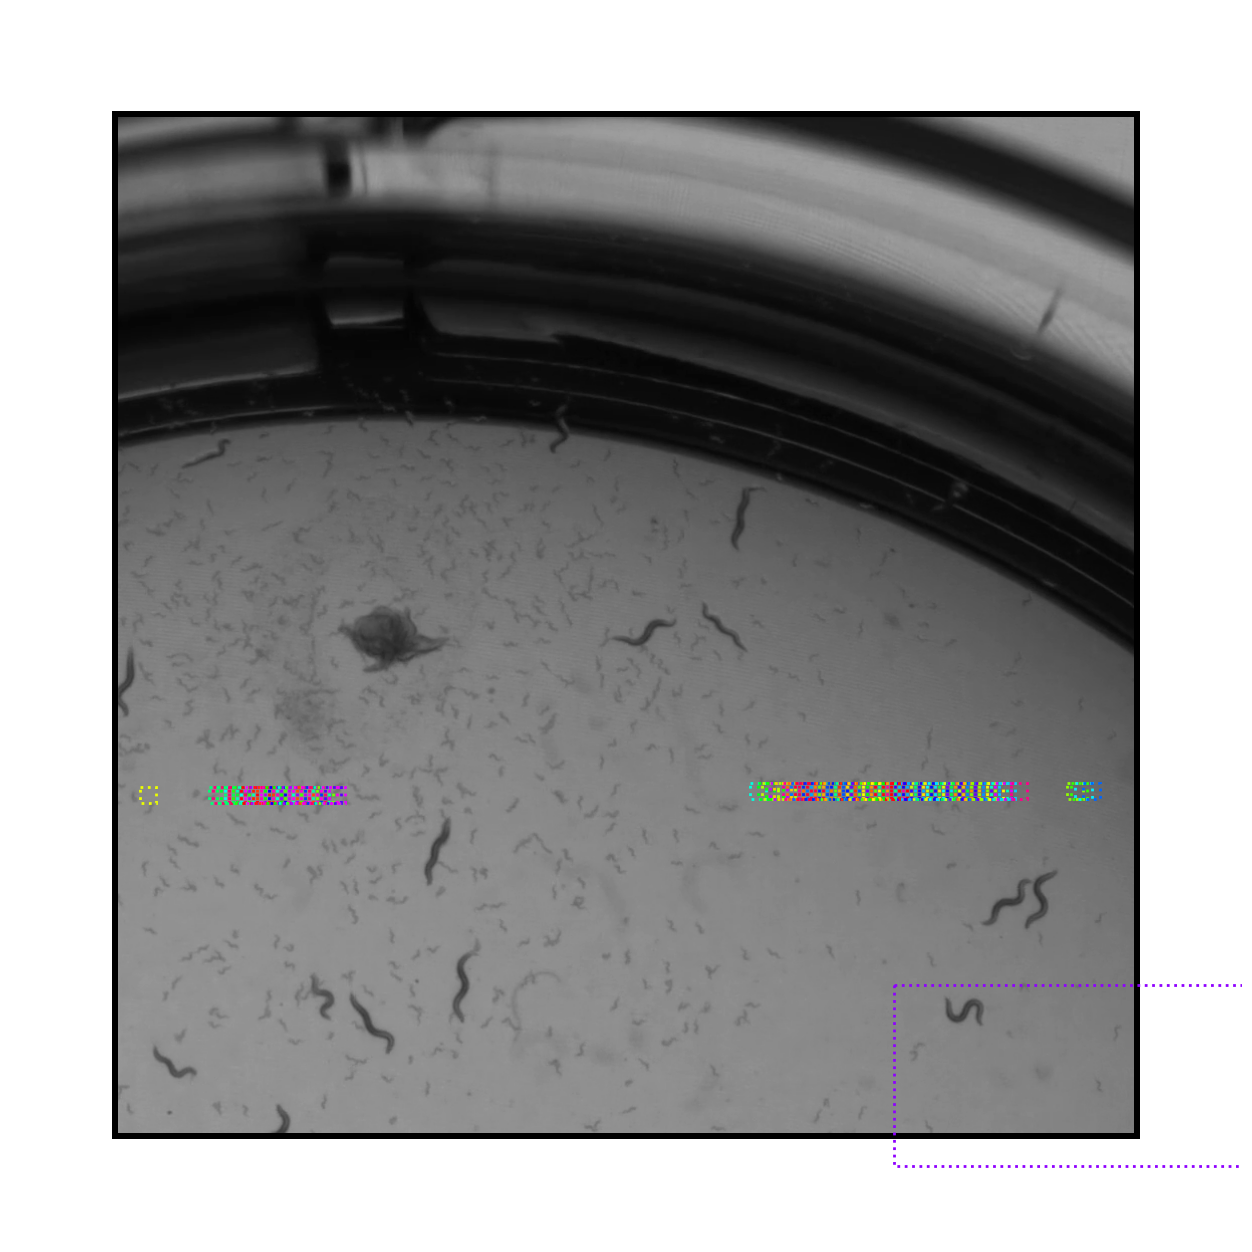

In [ ]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

In [ ]:
print("Target RPN BBox Deltas (first 5):", target_rpn_bbox[:5])

Target RPN BBox Deltas (first 5): [[-0.88388348 -2.20970869  1.76674553 -0.74639875]
 [-1.76776695 -1.54679608  3.4657359   1.5798242 ]
 [ 2.43067956  2.65165043  3.62077777 -0.28119859]
 [-1.10485435  2.65165043  3.62077777 -0.28119859]
 [-0.88388348  3.53553391  2.82035069  4.07198212]]


In [ ]:
# Original anchors (pre-NMS)
print("Pre-NMS Anchors (first 5):", rpn["pre_nms_anchors"][0, :5])

# Refined anchors (after deltas)
print("Refined Anchors (first 5):", rpn["refined_anchors"][0, :5])


Pre-NMS Anchors (first 5): [[-0.01105934  0.31509593  0.01008183  0.32517776]
 [-0.01105934  0.319006    0.01008183  0.32908782]
 [-0.01105934  0.3229161   0.01008183  0.3329979 ]
 [-0.01105934  0.32682616  0.01008183  0.33690798]
 [-0.01105934  0.33073622  0.01008183  0.34081805]]
Refined Anchors (first 5): [[-0.02836174  0.3091373  -0.00330765  0.3343963 ]
 [-0.03079394  0.31318086 -0.00087074  0.33953744]
 [-0.034099    0.3170417  -0.00183865  0.3424051 ]
 [-0.03558289  0.31959933 -0.0022651   0.34875473]
 [-0.0373318   0.3241444  -0.004669    0.3525305 ]]


In [ ]:
def clip_boxes(boxes, shape):
    """Clip boxes to image boundaries."""
    # Clip y1, y2, x1, x2
    boxes[:, 0] = np.maximum(np.minimum(boxes[:, 0], shape[0] - 1), 0)
    boxes[:, 1] = np.maximum(np.minimum(boxes[:, 1], shape[1] - 1), 0)
    boxes[:, 2] = np.maximum(np.minimum(boxes[:, 2], shape[0] - 1), 0)
    boxes[:, 3] = np.maximum(np.minimum(boxes[:, 3], shape[1] - 1), 0)
    return boxes

# Apply clipping to refined anchors
clipped_refined_anchors = clip_boxes(refined_anchors, image.shape)
print("Clipped Refined Anchors (first 5):", clipped_refined_anchors[:5])

Clipped Refined Anchors (first 5): [[291.      435.      345.      456.00003]
 [325.99997  66.      358.      119.     ]
 [373.      616.      438.      638.     ]
 [373.      616.      438.      638.     ]
 [503.99997 494.      534.      562.     ]]


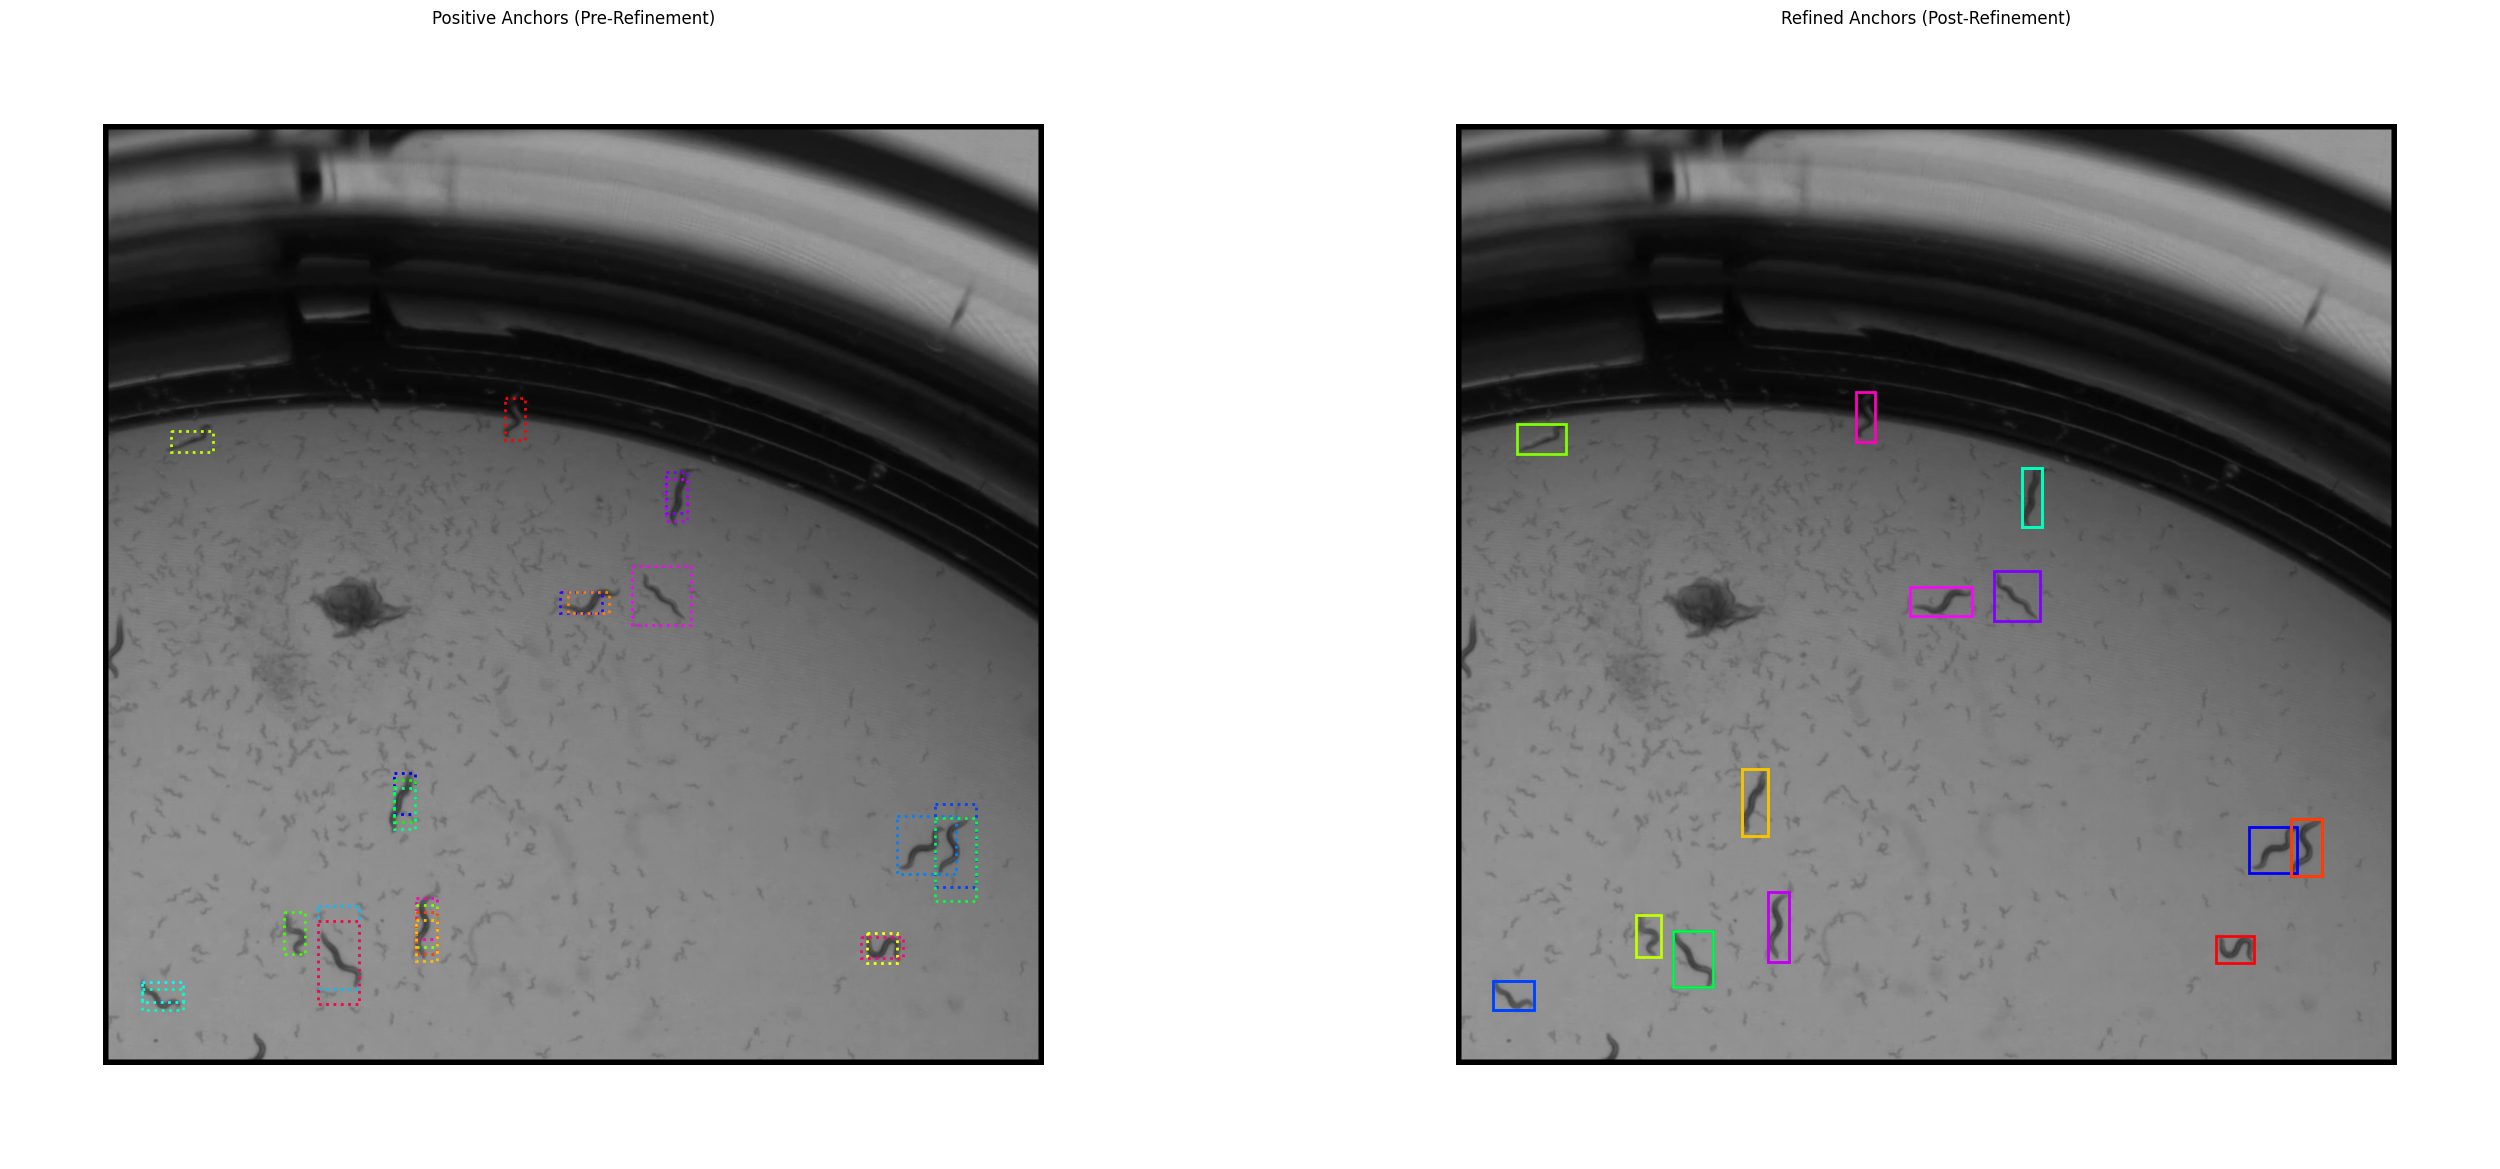

In [ ]:
# Visualize the refined anchors after clipping
limit = 50  # Set a limit for the number of anchors to display
ax = get_ax(1, 2)

# Visualize original anchors (before deltas)
visualize.draw_boxes(image, 
                     boxes=positive_anchors[:limit], 
                     refined_boxes=None, 
                     title="Positive Anchors (Pre-Refinement)", 
                     ax=ax[0])

# Visualize refined anchors (after deltas)
visualize.draw_boxes(image, 
                     boxes=None, 
                     refined_boxes=clipped_refined_anchors, 
                     title="Refined Anchors (Post-Refinement)", 
                     ax=ax[1])

# Show the plot
plt.show()


In [ ]:
print(clipped_refined_anchors.shape)

(24, 4)


Shape of clipped_refined_anchors: (24, 4)
Shape of scores: (24,)


TypeError: 'NoneType' object cannot be interpreted as an integer

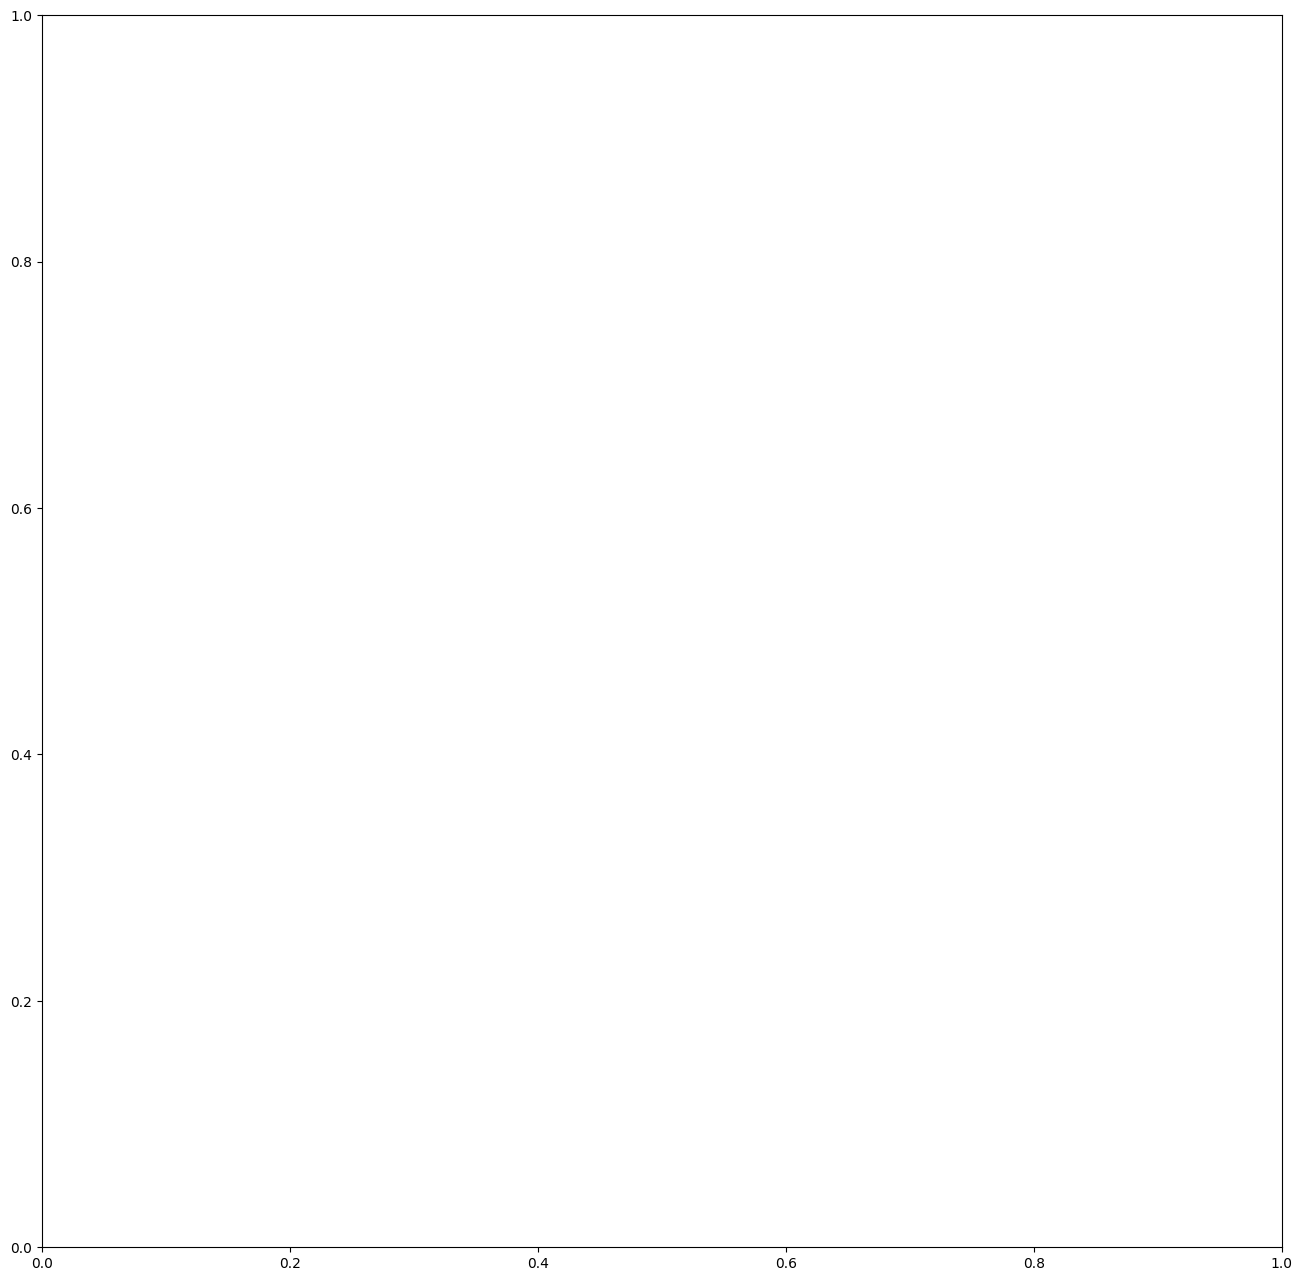

In [ ]:
import tensorflow as tf
batch_index=0

# Die Anzahl der Boxen (z.B. von clipped_refined_anchors)
num_boxes = clipped_refined_anchors.shape[0]  # Sollte 24 sein

# Extrahiere die Scores für die verfeinerten Anker (clipped_refined_anchors)
# Nutze die entsprechenden Indizes oder wähle sicher die Scores, die zu diesen Boxen gehören
scores = rpn["rpn_class"][batch_index, :num_boxes, 1]  # Shape muss mit num_boxes übereinstimmen

# Überprüfe die Form der Boxen und Scores
print("Shape of clipped_refined_anchors:", clipped_refined_anchors.shape)
print("Shape of scores:", scores.shape)

# Führe NMS durch
proposal_count = 50  # Anzahl der Boxen, die du nach NMS behalten willst (maximal 24 in diesem Fall)
nms_threshold = 0.7  # Threshold für NMS

indices = tf.image.non_max_suppression(
    clipped_refined_anchors, scores, proposal_count, iou_threshold=nms_threshold
)

# Wähle die Boxen nach NMS aus
refined_anchors_after_nms = tf.gather(clipped_refined_anchors, indices)

# Visualisiere die Boxen nach NMS
num_nms_boxes = tf.shape(refined_anchors_after_nms)[0]
limit = tf.minimum(num_nms_boxes, 24)  # Maximal 24 Boxen visualisieren
visualize.draw_boxes(image, refined_boxes=refined_anchors_after_nms[:limit], ax=get_ax(), title="Refined Anchors after NMS")



In [ ]:
print("Post NMS Anchor Indices (first 5):", rpn["post_nms_anchor_ix"][:5])
print("Number of valid NMS Anchors:", len(rpn["post_nms_anchor_ix"]))

Post NMS Anchor Indices (first 5): [0 1 2 3 4]
Number of valid NMS Anchors: 1000


In [ ]:
# Check the refined anchors after clipping and NMS
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
print("Refined Anchors Clipped after NMS (first 5):", rpn["refined_anchors_clipped"][0, ixs][:5])

Refined Anchors Clipped after NMS (first 5): [[0.         0.3091373  0.         0.3343963 ]
 [0.         0.31318086 0.         0.33953744]
 [0.         0.3170417  0.         0.3424051 ]
 [0.         0.31959933 0.         0.34875473]
 [0.         0.3241444  0.         0.3525305 ]]


In [ ]:
# Refined anchors before NMS (manually calculated, working fine)
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV
)
refined_anchors = clip_boxes(refined_anchors, image.shape)

# Boxen nach NMS
nms_anchors = rpn["refined_anchors_clipped"][0]

# Vergleiche die Boxen
print("Refined Anchors (first 5):", refined_anchors[:5])
print("NMS Anchors (first 5):", nms_anchors[:5])

Refined Anchors (first 5): [[291.      435.      345.      456.00003]
 [325.99997  66.      358.      119.     ]
 [373.      616.      438.      638.     ]
 [373.      616.      438.      638.     ]
 [503.99997 494.      534.      562.     ]]
NMS Anchors (first 5): [[0.         0.3091373  0.         0.3343963 ]
 [0.         0.31318086 0.         0.33953744]
 [0.         0.3170417  0.         0.3424051 ]
 [0.         0.31959933 0.         0.34875473]
 [0.         0.3241444  0.         0.3525305 ]]


In [ ]:
print("RPN NMS Threshold:", model.config.RPN_NMS_THRESHOLD)

RPN NMS Threshold: 0.75


In [ ]:
# Get the refined anchors after NMS
refined_anchors_clipped = rpn["refined_anchors_clipped"][0, ixs]

# Compute width and height of the boxes
widths = refined_anchors_clipped[:, 2] - refined_anchors_clipped[:, 0]
heights = refined_anchors_clipped[:, 3] - refined_anchors_clipped[:, 1]

# Print the sizes of the first few boxes
print("Widths of anchors after NMS (first 5):", widths[:5])
print("Heights of anchors after NMS (first 5):", heights[:5])

Widths of anchors after NMS (first 5): [0. 0. 0. 0. 0.]
Heights of anchors after NMS (first 5): [0.02525899 0.02635658 0.02536342 0.0291554  0.02838612]


In [ ]:
print("Clipped Refined Anchors after NMS (first 5):", refined_anchors_clipped[:5])

Clipped Refined Anchors after NMS (first 5): [[0.         0.3091373  0.         0.3343963 ]
 [0.         0.31318086 0.         0.33953744]
 [0.         0.3170417  0.         0.3424051 ]
 [0.         0.31959933 0.         0.34875473]
 [0.         0.3241444  0.         0.3525305 ]]


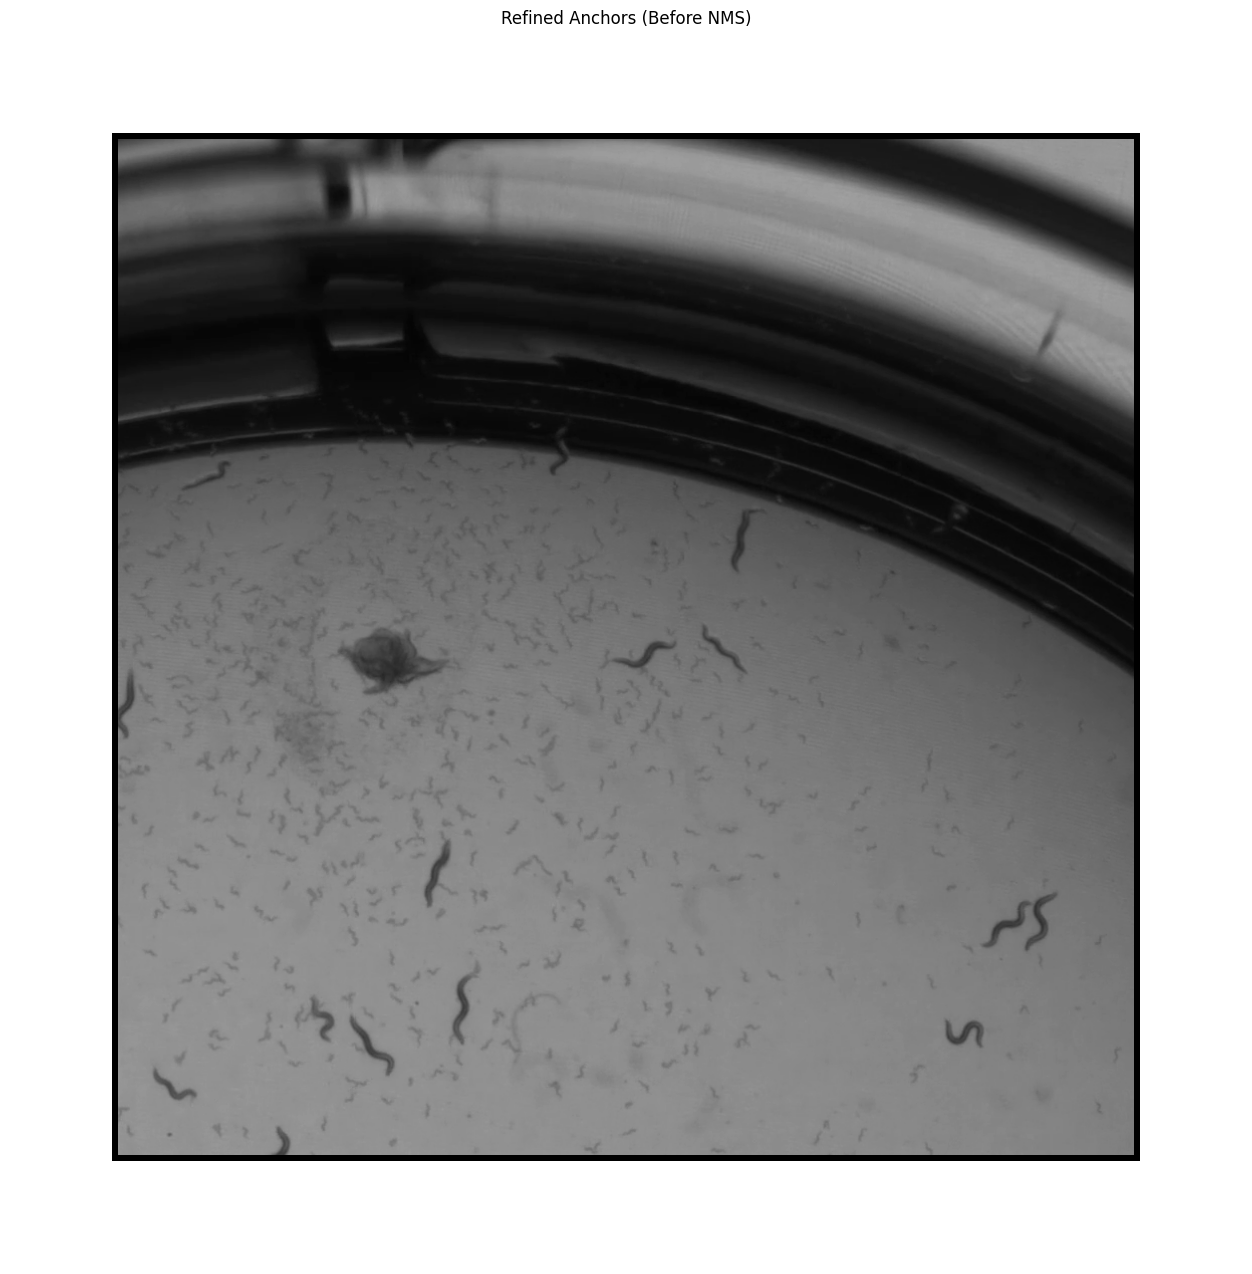

In [ ]:
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped, title="Refined Anchors (Before NMS)", ax=get_ax())



In [ ]:
# Refined anchors before NMS (manually calculated, working fine)
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV
)
refined_anchors = clip_boxes(refined_anchors, image.shape)

# Boxen nach NMS
nms_anchors = rpn["refined_anchors_clipped"][0]

# Vergleiche die Boxen
print("Refined Anchors (first 5):", refined_anchors[:5])
print("NMS Anchors (first 5):", nms_anchors[:5])

Refined Anchors (first 5): [[743.      133.      765.      155.     ]
 [743.      133.      765.      155.     ]
 [490.       59.      539.       84.     ]
 [484.       96.      554.      119.99999]
 [484.       96.      554.      119.99999]]
NMS Anchors (first 5): [[0.         0.         0.00245945 0.02430119]
 [0.00373875 0.         0.01078156 0.02490821]
 [0.00147916 0.         0.0118335  0.07072232]
 [0.00215955 0.         0.01272685 0.05861107]
 [0.         0.         0.00801792 0.04949918]]


### Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

#### 2.a Proposal Classification
Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [ ]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

2024-09-05 15:30:40.057820: W tensorflow/c/c_api.cc:304] Operation '{name:'ROI/packed_2' id:6050 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node ROI/packed_2}} = Pack[N=1, T=DT_FLOAT, _has_manual_control_dependencies=true, axis=0, _device="/device:CPU:0"](ROI/Pad)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-09-05 15:30:40.179397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-05 15:30:40.406619: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -45 } dim { size

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:  -18.56771  max:   20.06798  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.15172  max:    0.99117  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    0.00000  float32


In [ ]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
if np.any(det_class_ids == 0):
    print("Es gibt Detektionen mit der Klassen-ID 0.")
else:
    print("Keine Detektionen mit der Klassen-ID 0.")
# det_count = np.where(det_class_ids == 0)[0][0]
# det_class_ids = det_class_ids[:det_count]
# detections = mrcnn['detections'][0, :det_count]

# print("{} detections: {}".format(
#     det_count, np.array(dataset.class_names)[det_class_ids]))

# captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
#             for c, s in zip(detections[:, 4], detections[:, 5])]
# visualize.draw_boxes(
#     image, 
#     refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
#     visibilities=[2] * len(detections),
#     captions=captions, title="Detections",
#     ax=get_ax())

Keine Detektionen mit der Klassen-ID 0.


image ID: c_elegans.12 (11) ./dataset/val/0637-7.png
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  156.00000  uint8
image_meta               shape: (14,)                 min:    1.00000  max: 1024.00000  int64
gt_class_id              shape: (31,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (31, 4)               min:    9.00000  max: 1012.00000  int32
gt_mask                  shape: (1024, 1024, 31)      min:    0.00000  max:    1.00000  bool


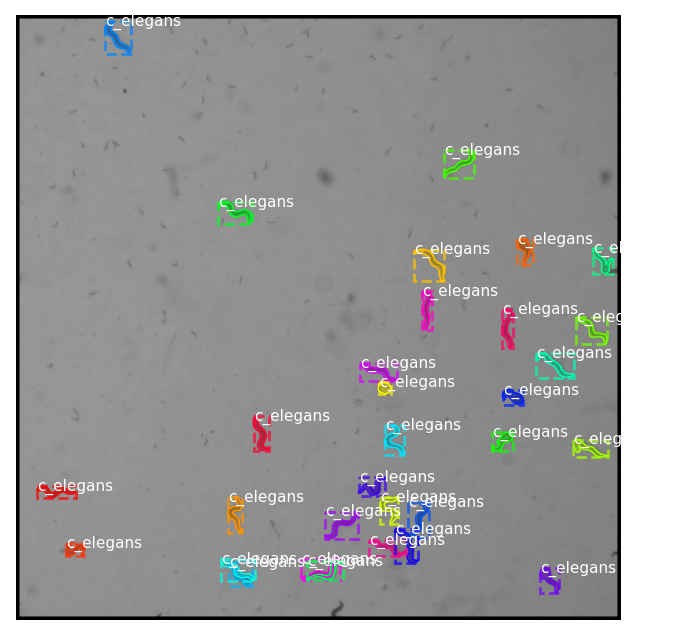

In [25]:
from mrcnn import utils
# Test on a random image
image_id = np.random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config,
                           image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
mask = utils.expand_mask(gt_bbox, gt_mask, image.shape)
log("original_image", image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", mask)

visualize.display_instances(image, gt_bbox, mask, gt_class_id,
                            dataset.class_names, figsize=(8, 8))

In [26]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

2024-09-11 16:30:43.976885: W tensorflow/c/c_api.cc:304] Operation '{name:'mrcnn_detection/Reshape_1' id:6831 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node mrcnn_detection/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true, _device="/device:CPU:0"](mrcnn_detection/packed, mrcnn_detection/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-09-11 16:30:44.397177: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -45 } dim { size: -308 } dim { size: -309 } dim { size: 256 } } } inputs { dtype: DT_FLOAT

detections               shape: (1, 100, 6)           min:    0.00000  max:    0.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.35106  max:    0.99466  float32
0 detections: []
